In [1]:
from bta import read_block
from bta.analysis import modify_time_ranges, get_filtered_stream_data, get_time_ranges
import numpy as np
from matplotlib import pyplot as plt
demo = r"C:\dev\projects\better tdt api\max_data"
data = read_block(demo)

In [2]:
data

Epocs:   PrtA
         PrtB
Streams: ISOG
         GFPG
         Fi2d
         Fi2r
Scalars: Fi2i

In [3]:
prta = data.get_epoc("PrtA")
prtb = data.get_epoc("PrtB")
fi2i = data.get_scalar("Fi2i")
fi2d = data.get_stream("Fi2d")
fi2r = data.get_stream("Fi2r")
gfp = data.get_stream("GFPG")
iso = data.get_stream("ISOG")


In [49]:
from tdt import read_block
data = read_block(demo)
set(data.epocs.PrtA.data.tolist())


read from t=0s to t=2126.7s


{0.0, 192.0, 193.0, 196.0, 197.0}

In [43]:
# something is funky with bta data, so let's force tdt into the mix
prta.onset = data.epocs.PrtA.onset
prta.offset = data.epocs.PrtA.offset
prta.data = data.epocs.PrtA.data
gfp.data = data.streams.GFPG.data
iso.data = data.streams.ISOG.data

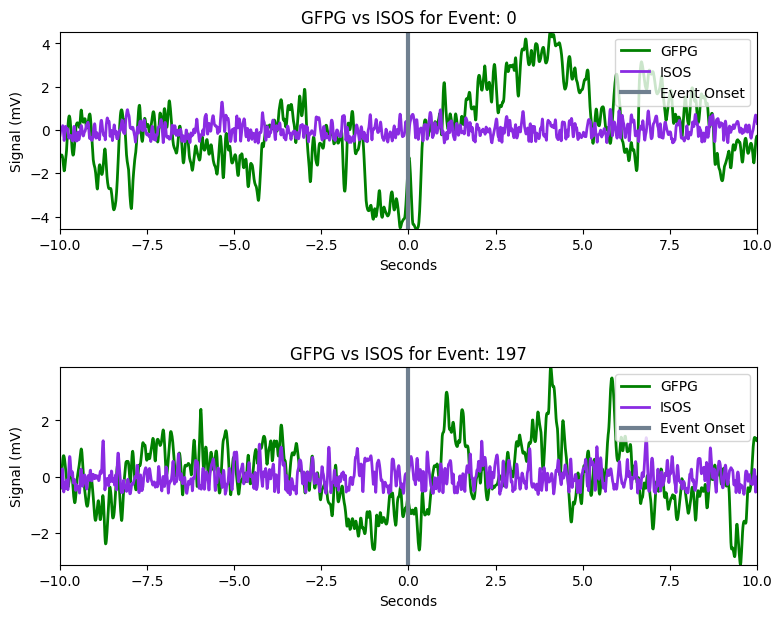

In [66]:
TRANGE = [-10, 20] # window size [start time relative to epoc onset, window duration]
BASELINE_PER = [-10, -6] # baseline period within our window
ARTIFACT = float("inf")
fig = plt.figure(figsize=(9, 20))
# increase spacing between subplots
fig.subplots_adjust(hspace=0.7)
for idx, event_code in enumerate([0, 197]):
    trs = get_time_ranges(prta, values=[event_code])
    filtered_csp_trs = modify_time_ranges(prtb, TRANGE, trs)
    filtered_gcamp = get_filtered_stream_data(gfp, filtered_csp_trs)
    filtered_isos = get_filtered_stream_data(iso, filtered_csp_trs)
    min1 = np.min([np.size(x) for x in filtered_gcamp])
    min2 = np.min([np.size(x) for x in filtered_isos])
    # filtered_gcamp = [x[1:min1] for x in filtered_gcamp]
    # filtered_isos = [x[1:min2] for x in filtered_isos]

    # Downsample and average 10x via a moving window mean
    N = 10 # Average every 10 samples into 1 value
    F405 = []
    F465 = []
    for lst in filtered_isos:
        small_lst = []
        for i in range(0, min2, N):
            small_lst.append(np.mean(lst[i:i+N-1])) # This is the moving window mean
        F405.append(small_lst)

    for lst in filtered_gcamp: 
        small_lst = []
        for i in range(0, min1, N):
            small_lst.append(np.mean(lst[i:i+N-1]))
        F465.append(small_lst)


    #Create a mean signal, standard error of signal, and DC offset
    meanF405 = np.mean(F405, axis=0)
    stdF405 = np.std(F405, axis=0)/np.sqrt(len(filtered_isos))
    dcF405 = np.mean(meanF405)
    meanF465 = np.mean(F465, axis=0)
    stdF465 = np.std(F465, axis=0)/np.sqrt(len(filtered_gcamp))
    dcF465 = np.mean(meanF465)

    # Create the time vector for each stream store
    ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/gfp.fs*N
    ts2 = TRANGE[0] + np.linspace(1, len(meanF405), len(meanF405))/iso.fs*N

    # Subtract DC offset to get signals on top of one another
    meanF405 = meanF405 - dcF405
    meanF465 = meanF465 - dcF465

    # Start making a figure with 4 subplots
    ax0 = fig.add_subplot(5, 1, idx+1)

    # Plotting the traces
    p1, = ax0.plot(ts1, meanF465, linewidth=2, color='green', label='GFPG')
    p2, = ax0.plot(ts2, meanF405, linewidth=2, color='blueviolet', label='ISOS')

    # Plotting standard error bands
    p3 = ax0.fill_between(ts1, meanF465+stdF465, meanF465-stdF465,
                          facecolor='green', alpha=0.2)
    p4 = ax0.fill_between(ts2, meanF405+stdF405, meanF405-stdF405,
                          facecolor='blueviolet', alpha=0.2)

    # Plotting a line at t = 0
    p5 = ax0.axvline(x=0, linewidth=3, color='slategray', label='Event Onset')

    # Finish up the plot
    ax0.set_xlabel('Seconds')
    ax0.set_ylabel('Signal (mV)')
    ax0.set_title(f'GFPG vs ISOS for Event: {event_code}')
    ax0.legend(handles=[p1, p2, p5], loc='upper right')
    ax0.set_ylim(min(np.min(meanF465-stdF465), np.min(meanF405-stdF405)),
                max(np.max(meanF465+stdF465), np.max(meanF405+stdF405)))
    ax0.set_xlim(TRANGE[0], TRANGE[1]+TRANGE[0])